In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
#from arch import arch_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

In [122]:
data = pd.read_csv("ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.rename(columns={'GDP (current US$)': 'GDP'}, inplace=True)
data["GDP"] = data["GDP"].astype(float)
data.index = pd.to_datetime(data.index)
data

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [123]:
#data.info()

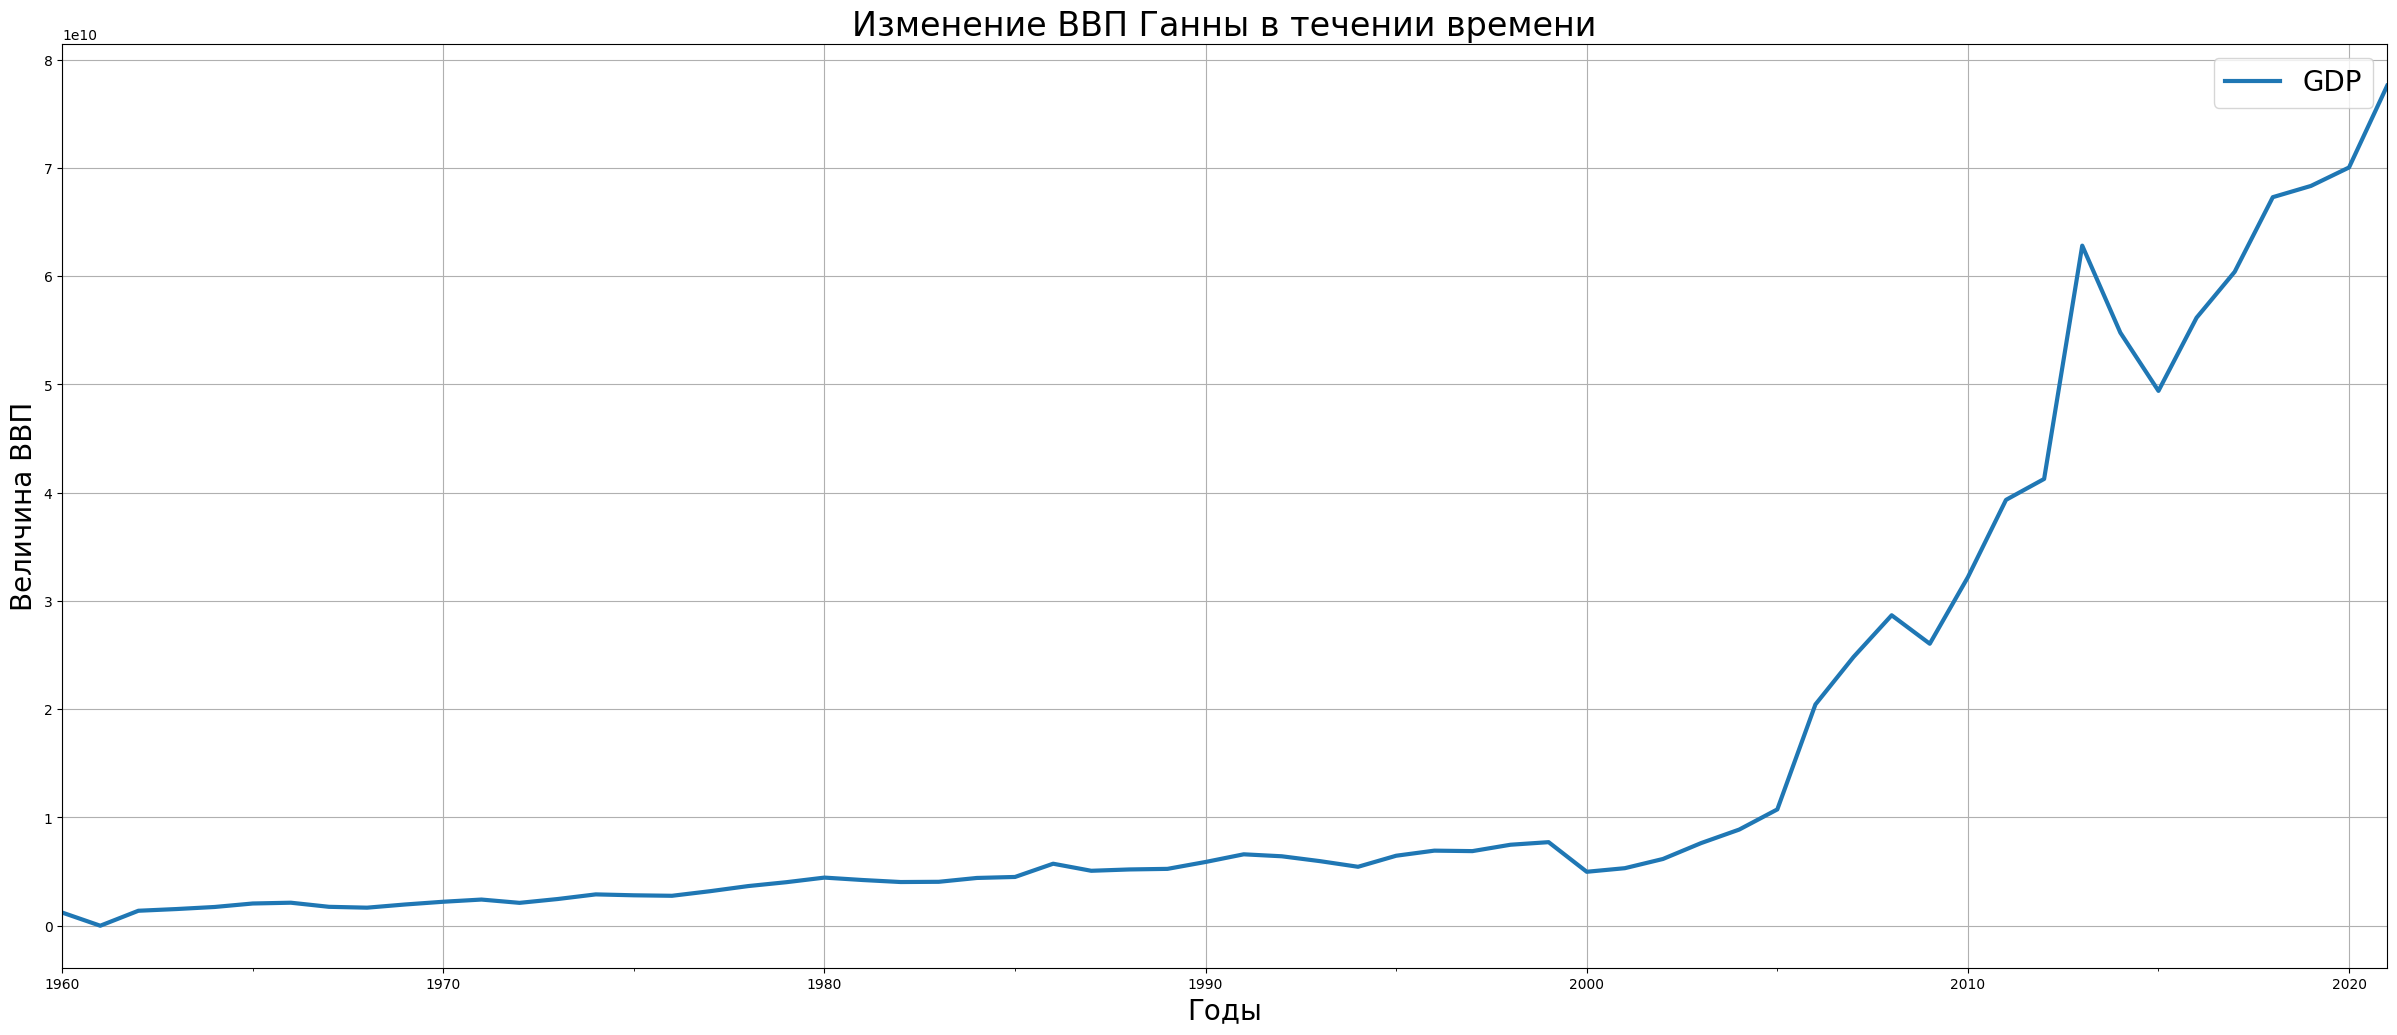

In [124]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot(legend=True,
    title='Изменение ВВП Ганны в течении времени',
    grid=True,
    xlabel='Годы',
    ylabel='Величина ВВП')
plt.show()

вопрос 1

Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде. 

Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

Вывод: 

На графике видно, что тренд возрастающий на всем продяжении, но начиная с 2000 года рост стремительно увеличился. Сезонность не просматривается. (Возникает вопрос к значению ВВП в 1961 году (=0),но это вопрос к качеству данных..)

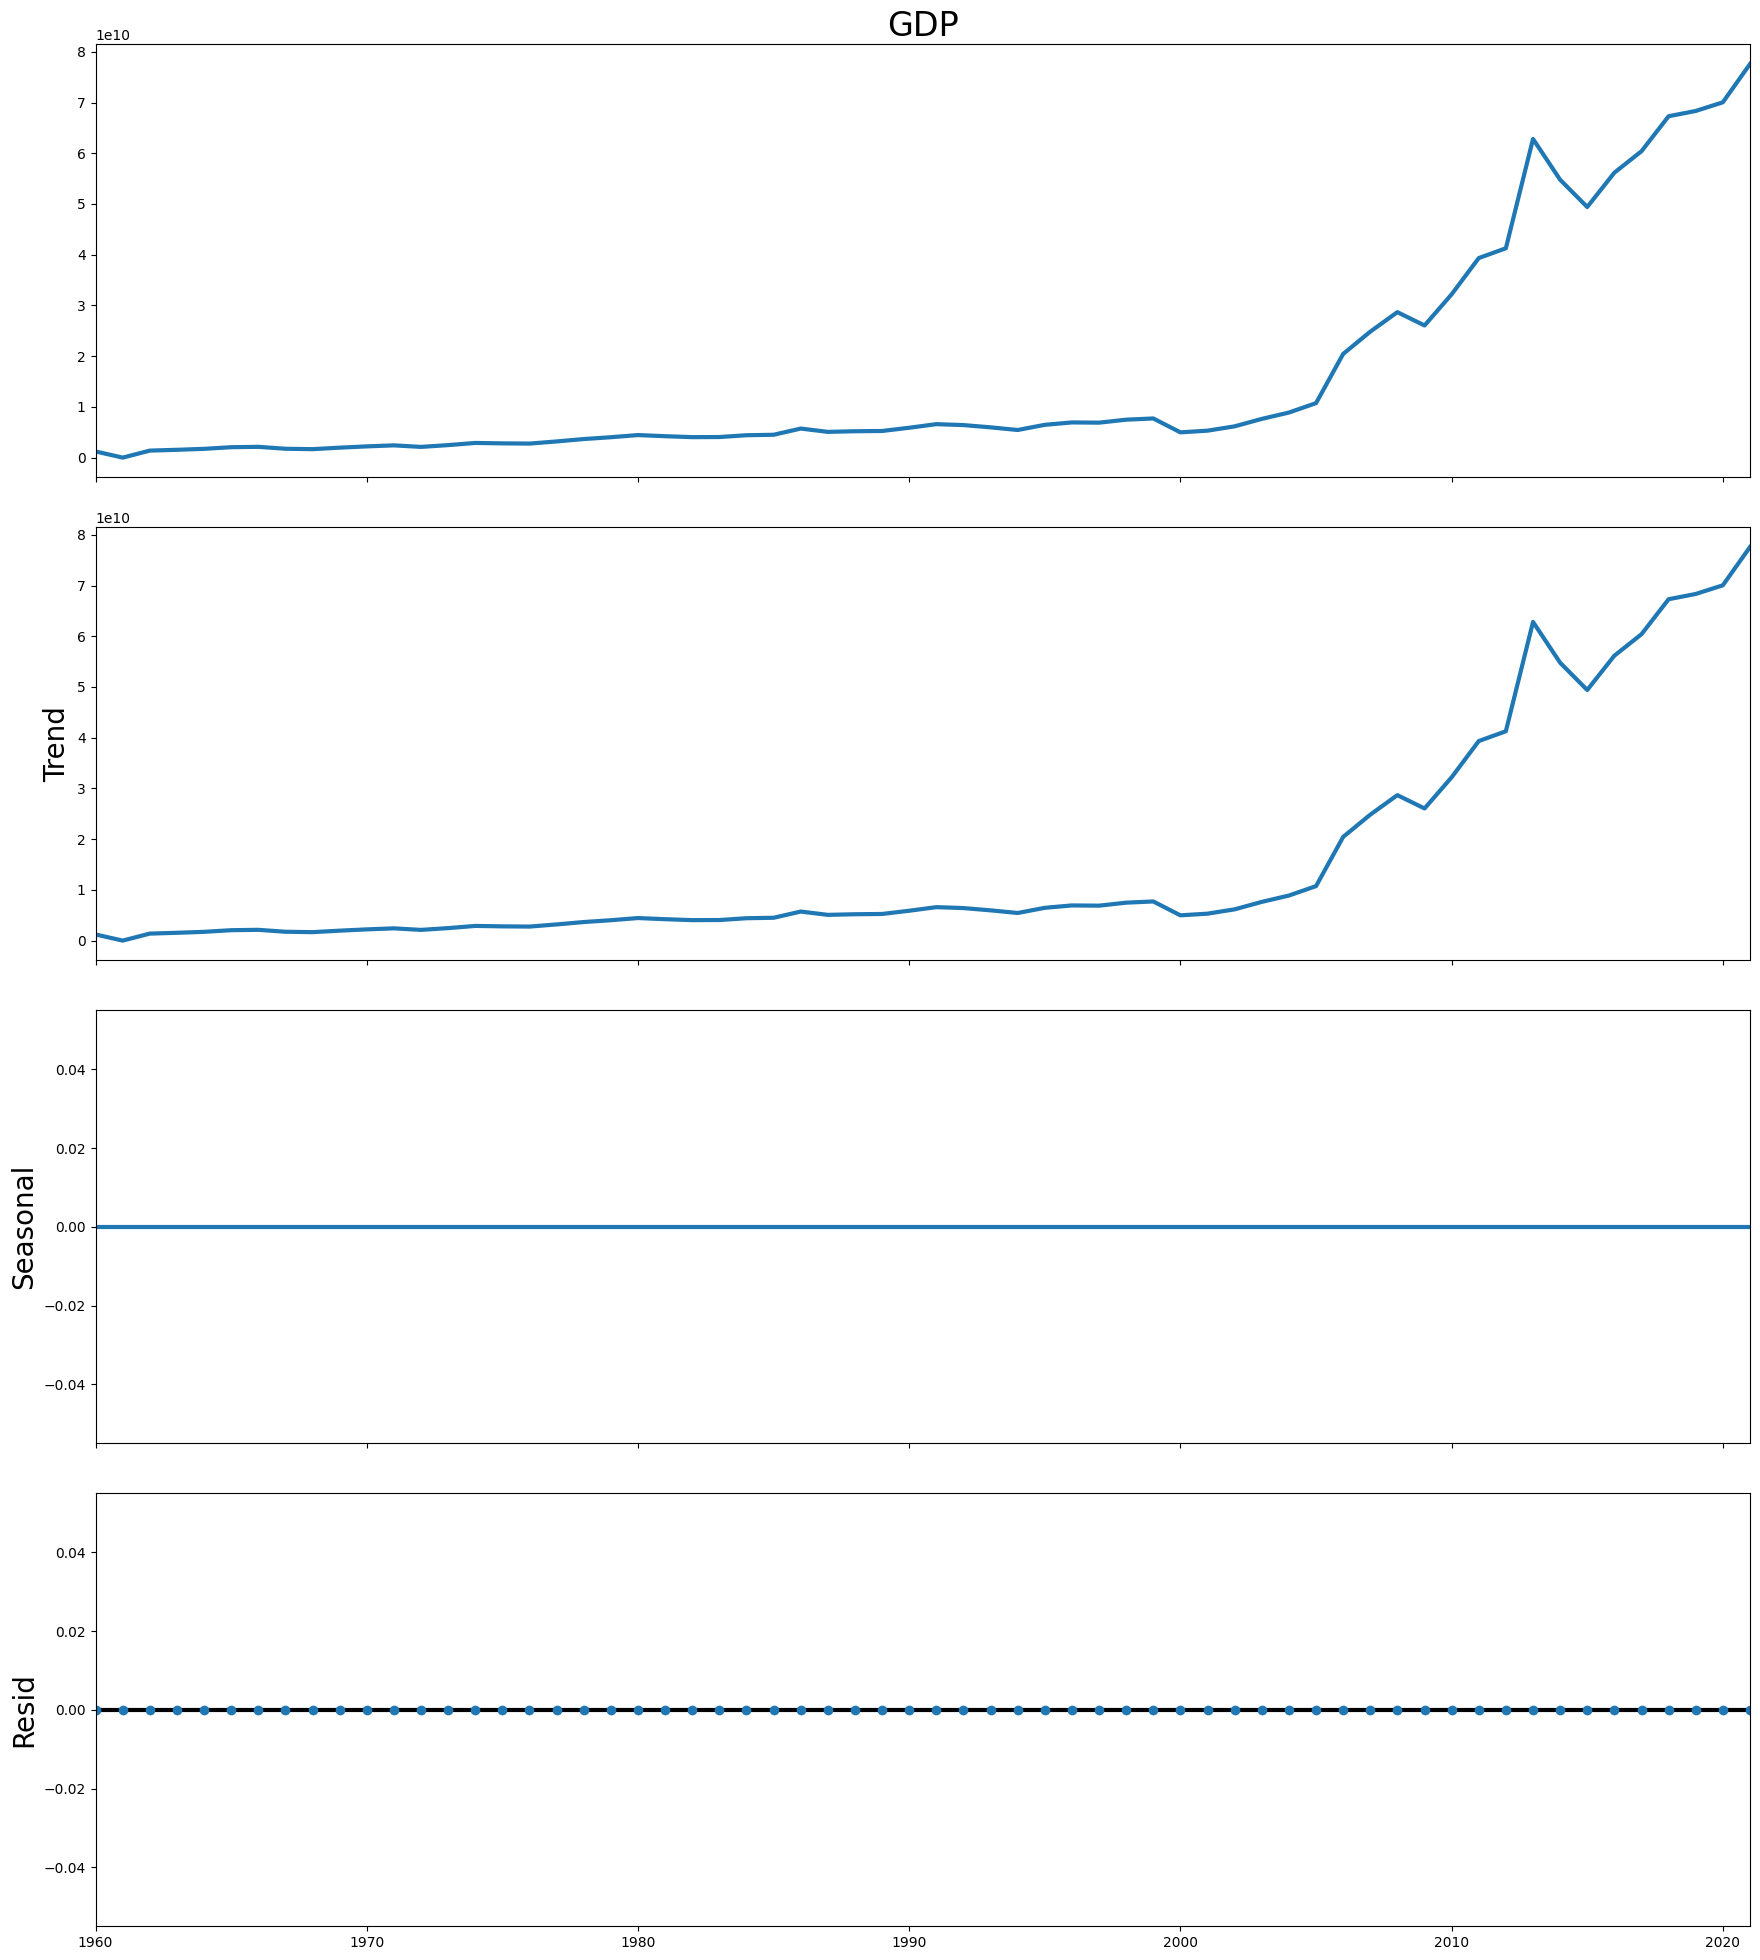

In [140]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(data["GDP"])
result.plot()
plt.show()

Разделим данные на тренировочную и тестовую выборки в соответствии с заданием

In [141]:
data_train = data.iloc[:-3]
data_test = data.iloc[-3:]
data_train.shape, data_test.shape

((59, 1), (3, 1))

вопрос 2

Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

Пример: train_df.spx.rolling(window=2).mean().

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

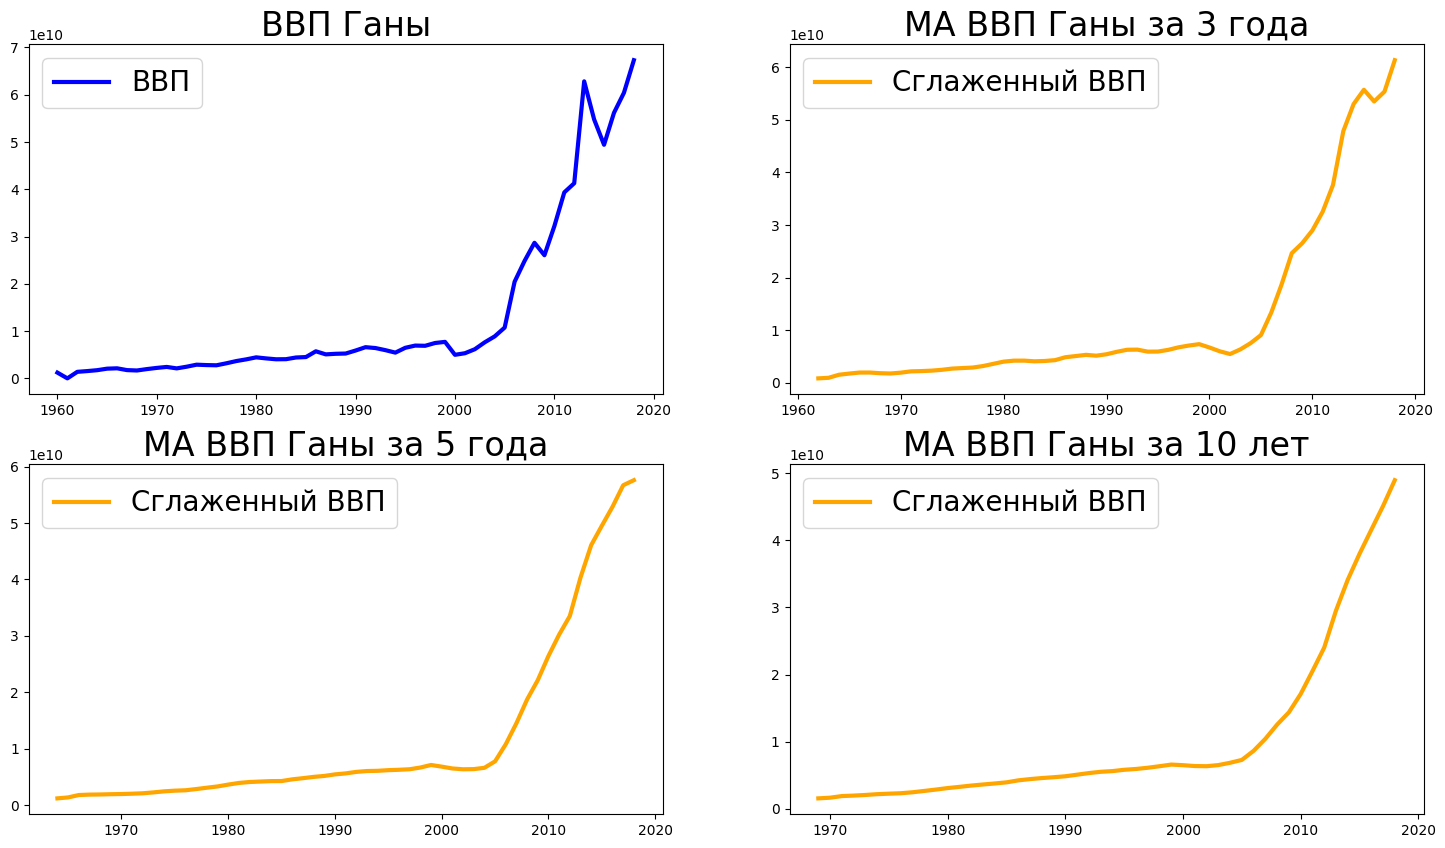

In [142]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(data_train.GDP, color="blue", label="ВВП")
ax[0, 0].set_title("ВВП Ганы", size=24)
ax[0, 0].legend()

# Окно в месяц (Window = 3)
ax[0, 1].plot(
    data_train.GDP.rolling(window=3).mean(),
    color="orange",
    label="Сглаженный ВВП",
)

ax[0, 1].set_title("MA ВВП Ганы за 3 года", size=24)
ax[0, 1].legend()

# Окно в месяц (Window = 5)
ax[1, 0].plot(
    data_train.GDP.rolling(window=5).mean(),
    color="orange",
    label="Сглаженный ВВП",
)

ax[1, 0].set_title("MA ВВП Ганы за 5 года", size=24)
ax[1, 0].legend()

# Окно в год (Window = 10)
ax[1, 1].plot(
    data_train.GDP.rolling(window=10).mean(),
    color="orange",
    label="Сглаженный ВВП",
)

ax[1, 1].set_title("MA ВВП Ганы за 10 лет", size=24)
ax[1, 1].legend()

plt.show()

Чем меньше окно сдвига MA, тем больше модель реагирует на выборсы. Оптимальнее использовать не очень маленькие и не очень большие значения окна, описываающие изменение показателя без "скачков" и "рывков", например, 10.

Вопрос 3

С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.
Примечание. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.

Параметры p и q выберите по коррелограммам ACF и PACF.
Примечание. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

In [144]:
def stat_test(data):

    test = adfuller(data)

    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])

    if test[0] > test[4]['5%']:
        print ('Есть единичные корни, ряд не стационарен.')

    else:
        print ('Единичных корней нет, ряд стационарен.')

stat_test(data_train)

adf:  0.652906697488536
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Есть единичные корни, ряд не стационарен.


Так как ряд не стационарен, то проведем дифференцирование.

In [145]:
data_train_diff_1 = data_train.diff().dropna()

stat_test(data_train_diff_1)

adf:  -1.6702483038320755
p-value:  0.44650293297139027
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
Есть единичные корни, ряд не стационарен.


In [146]:
data_train_diff_2 = data_train_diff_1.diff().dropna()

stat_test(data_train_diff_2)

adf:  -2.640869056128487
p-value:  0.0848411691783772
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Есть единичные корни, ряд не стационарен.


In [147]:
data_train_diff_3 = data_train_diff_2.diff().dropna()

stat_test(data_train_diff_3)

adf:  -4.779623784828547
p-value:  5.9483276402245235e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Единичных корней нет, ряд стационарен.


Найден параметр d=3 (требуется найти параметры p и q). Используем для этого коррелограммы

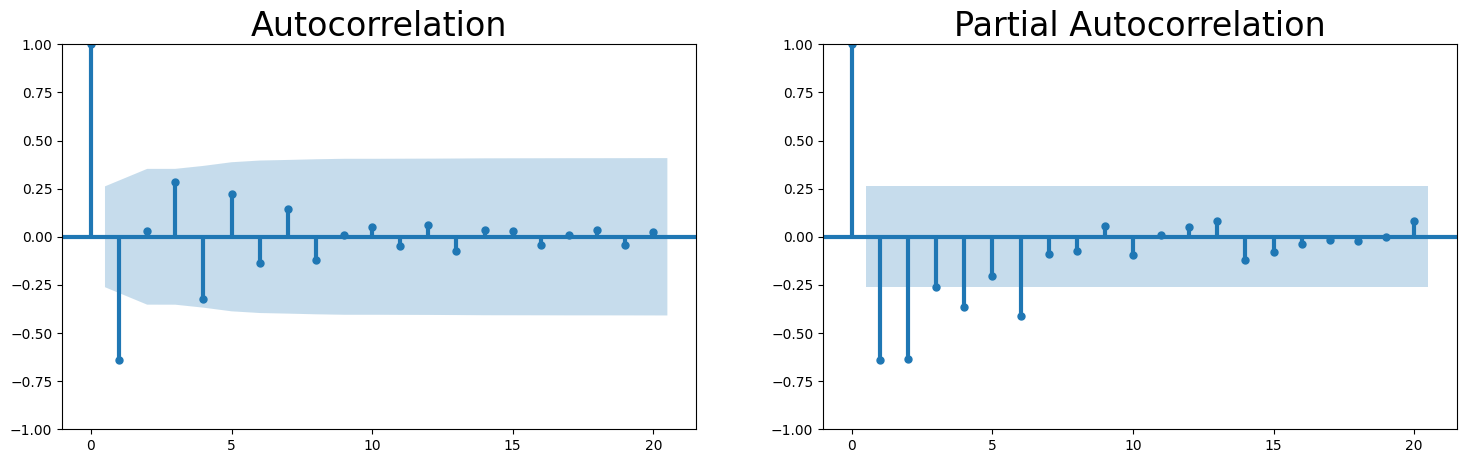

In [148]:
def plot_acf_pacf(series):

    plt.rcParams['figure.figsize'] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=20)
    sgt.plot_pacf(series, ax=axes[1], lags=20, method='ywm')
    plt.show()


plot_acf_pacf(data_train_diff_3)

Из графика частичной автокорреляции берем значение  p=2 и q=1. 

Строим модели ARIMA/ SARIMA

In [133]:
arima_model = ARIMA(data_train, order=(2, 3, 1))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 03 Jan 2025   AIC                           2659.231
Time:                        14:25:12   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.0

In [149]:
sarimax_model = SARIMAX(data_train, order=(2, 3, 1))
sarimax_model_fit = sarimax_model.fit()
print(sarimax_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 03 Jan 2025   AIC                           2659.231
Time:                        14:27:29   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.0

Проведем подбор параметров при помощи pamdarima

In [150]:
pamdarima_model = pm.auto_arima(
    data_train,
    start_p=1,
    d=3,
    start_q=1,
    max_p=5,
    max_q=5,
    max_d=5,
    D=3,
    start_P=0,
    # m=1,
    test='adf',
    error_action='ignore',
    trace=True,
)

# Выводим результат.
print(pamdarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.37 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.16 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.20 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.04 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.11 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.11 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.63 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.10 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 2.636 seconds
                               SARIMAX Results                                
Dep. Variable:          

Вопрос 4

Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

In [151]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=data_test.index[0], end=data_test.index[-1]
)


pred_df["GDP"] = data["GDP"]

forecast = arima_model_fit.get_forecast(len(data_test.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[data_test.index, "model_preds_lower"] = forecast_df["lower GDP"]
pred_df.at[data_test.index, "model_preds_upper"] = forecast_df["upper GDP"]

In [137]:
pred_df

,model_preds,GDP,model_preds_lower,model_preds_upper
year,,,,
1960-01-01,NaN,1.217087e+09,NaN,NaN
1961-01-01,NaN,0.000000e+00,NaN,NaN
1962-01-01,NaN,1.382353e+09,NaN,NaN
1963-01-01,NaN,1.540616e+09,NaN,NaN
1964-01-01,NaN,1.731092e+09,NaN,NaN
...,...,...,...,...
2017-01-01,NaN,6.040638e+10,NaN,NaN
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,7.368591e+10,6.833754e+10,6.269386e+10,8.467796e+10


Вопрос 5

Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

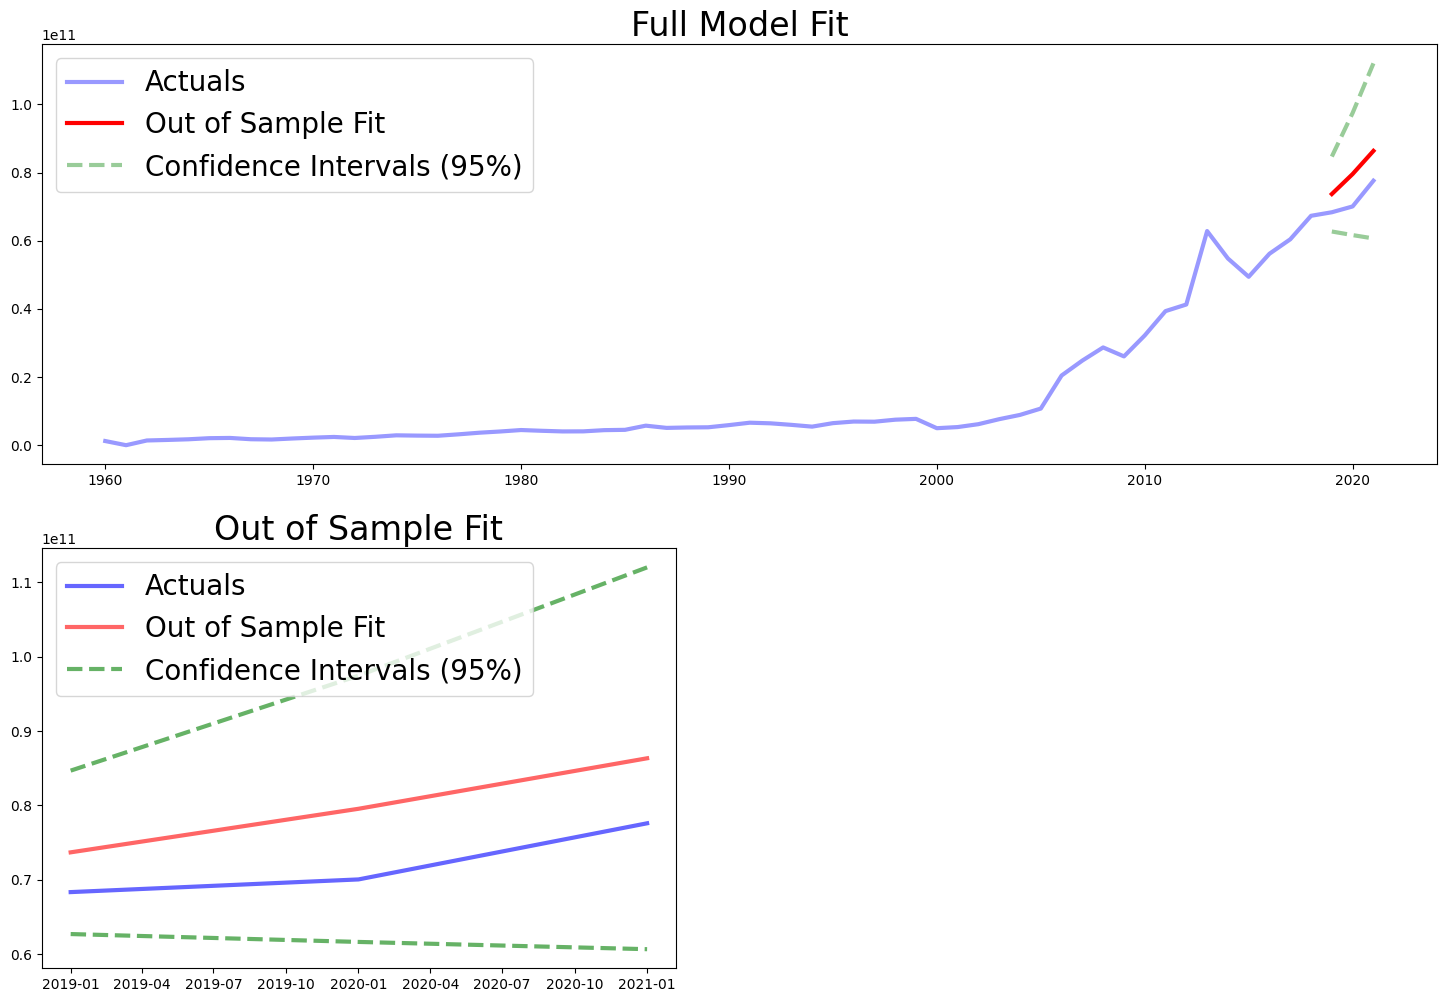

In [152]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[data_test.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[data_test.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[data_test.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[data_test.index]["GDP"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[data_test.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[data_test.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[data_test.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Вывод: Лучше всех предсказывает модель, выбранная по оптимальным параметрам с помощью auto_arima (2,3,1). 